# Invoice Extraction & Analytics Dashboard

This notebook provides:
- **End-to-end invoice extraction** from PDF files
- **Readable data display** of extracted invoices
- **Query functions** for filtering and analyzing invoices
- **Interactive visualizations** for spending analysis

---

## Features:
1. Process all invoices in the `data/` folder
2. Display extracted invoice data in tables
3. Query invoices by vendor, date range, etc.
4. Visualize spending patterns and trends


In [ ]:
# Import required libraries
import os
import sys
from pathlib import Path
from datetime import datetime, date
import json
from typing import List, Dict, Any, Optional
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Project imports
from invoice_extractor import EnhancedInvoiceExtractor
from database import InvoiceDatabase
from config import Config

print("✓ All libraries imported successfully!")
print(f"✓ Working directory: {os.getcwd()}")


✓ Using standard regex extractor (regex_extractor.py)
✓ All libraries imported successfully!
✓ Working directory: /Users/shubham/Desktop/Invoices


## 1. Initialize Components

Set up the invoice extractor and database connection.


In [2]:
# Initialize database
db = InvoiceDatabase("invoices.db")
print("✓ Database initialized")

# Initialize extractor
extractor = EnhancedInvoiceExtractor(
    api_key=Config.get_api_key() if Config.validate() else None,
    use_regex=True,  # Fastest, free for known vendors
    use_layoutlmv3=True,
    use_ocr=True
)
print("✓ Invoice extractor initialized")

# Data folder path
DATA_FOLDER = Path("data")
print(f"✓ Data folder: {DATA_FOLDER.absolute()}")


✓ Database initialized
✓ Regex extractor initialized (module: regex_extractor)
  Supported vendors: Frank's Quality Produce & Pacific Food Importers
Loading LayoutLMv3 model for structured extraction...
✓ LayoutLMv3 model loaded successfully
✓ Invoice extractor initialized
✓ Data folder: /Users/shubham/Desktop/Invoices/data


## 2. Process All Invoices

Extract invoice data from all PDF files in the data folder.


In [ ]:
def process_invoices_folder(data_folder: Path, extractor, database):
    """
    Process all PDF/image files in the data folder
    
    Returns:
        List of processed file results
    """
    # Find all supported files
    supported_extensions = ['.pdf', '.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp', '.gif']
    all_files = []
    for ext in supported_extensions:
        all_files.extend(list(data_folder.glob(f"*{ext}")))
        all_files.extend(list(data_folder.glob(f"*{ext.upper()}")))
    
    all_files = list(set(all_files))
    
    if not all_files:
        print(f"⚠ No supported files found in {data_folder}")
        return []
    
    print(f" Found {len(all_files)} file(s) to process\n")
    
    results = []
    processed_count = 0
    saved_count = 0
    
    for i, file_path in enumerate(all_files, 1):
        print(f"[{i}/{len(all_files)}] Processing: {file_path.name}")
        
        try:
            # Extract invoice data
            result = extractor.extract_robust(str(file_path))
            
            # Save to database
            if result.get('status') == 'success':
                db_result = database.save_extraction_result(result, str(file_path))
                if db_result['saved']:
                    saved_count += db_result['saved_pages']
                    print(f"  ✓ Saved {db_result['saved_pages']} invoice(s) to database")
                else:
                    print(f"  ⚠ Already exists or validation failed")
            else:
                print(f"  ✗ Extraction failed: {result.get('error', 'Unknown error')}")
            
            results.append({
                'file': file_path.name,
                'result': result,
                'status': result.get('status')
            })
            processed_count += 1
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results.append({
                'file': file_path.name,
                'status': 'error',
                'error': str(e)
            })
    
    print(f"\n{'='*60}")
    print(f" Processing Summary:")
    print(f"  Total files: {len(all_files)}")
    print(f"  Processed: {processed_count}")
    print(f"  Invoices saved: {saved_count}")
    print(f"{'='*60}")
    
    return results

# Process all invoices
if DATA_FOLDER.exists():
    processing_results = process_invoices_folder(DATA_FOLDER, extractor, db)
else:
    print(f"⚠ Data folder not found: {DATA_FOLDER}")
    processing_results = []


📄 Found 32 file(s) to process

[1/32] Processing: Copy of Inv_20076301_from_Franks_Quality_Produce_18887473_13748.pdf
Converting PDF to images: data/Copy of Inv_20076301_from_Franks_Quality_Produce_18887473_13748.pdf (DPI: 200)

Processing page 1/1...
  [1/4] Trying regex extraction (fastest, free)...
  [2/4] Trying LayoutLMv3 extraction (with layout understanding)...
  ✓ LayoutLMv3 extraction successful (confidence: 100.00%)
  ✓ Extraction successful using layoutlmv3
  ✓ Saved 1 invoice(s) to database
[2/32] Processing: Copy of ARPFIINVOEBTCHLASER (9).pdf
Converting PDF to images: data/Copy of ARPFIINVOEBTCHLASER (9).pdf (DPI: 200)

Processing page 1/4...
  [1/4] Trying regex extraction (fastest, free)...
  [2/4] Trying LayoutLMv3 extraction (with layout understanding)...
  LayoutLMv3 extraction error: index out of range in self
  [3/4] Trying OCR extraction (with cheap Claude Haiku)...
  ✓ Extraction successful using ocr

Processing page 2/4...
  [1/4] Trying regex extraction (fastes

## 3. Load Data from Database

Load all extracted invoices into a pandas DataFrame for analysis.


In [ ]:
def load_invoices_to_dataframe(database: InvoiceDatabase) -> pd.DataFrame:
    """
    Load all invoices from database into a pandas DataFrame
    
    Returns:
        DataFrame with invoice data
    """
    invoices = database.get_all_invoices()
    
    if not invoices:
        print("⚠ No invoices found in database")
        return pd.DataFrame()
    
    # Flatten invoice data for DataFrame
    invoice_rows = []
    for inv in invoices:
        invoice_rows.append({
            'id': inv['id'],
            'invoice_number': inv['invoice_number'],
            'vendor_name': inv['vendor_name'],
            'invoice_date': pd.to_datetime(inv['invoice_date']),
            'total_amount': float(inv['total_amount']),
            'line_items_count': len(inv.get('line_items', [])),
            'extraction_method': inv.get('extraction_method', 'unknown'),
            'confidence_score': float(inv.get('confidence_score', 0.0)) if inv.get('confidence_score') is not None else 0.0,
            'validated': bool(inv.get('validated', False)),
            'source_file': inv.get('source_pdf_name', ''),
            'created_at': pd.to_datetime(inv.get('created_at', datetime.now()))
        })
    
    df = pd.DataFrame(invoice_rows)
    
    # Add date columns for easier filtering
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    df['month_name'] = df['invoice_date'].dt.strftime('%B')
    df['quarter'] = df['invoice_date'].dt.quarter
    
    print(f"✓ Loaded {len(df)} invoices from database")
    print(f"  Date range: {df['invoice_date'].min().date()} to {df['invoice_date'].max().date()}")
    print(f"  Vendors: {df['vendor_name'].nunique()} unique vendors")
    print(f"  Total amount: ${df['total_amount'].sum():,.2f}")
    
    return df

# Load invoices
invoices_df = load_invoices_to_dataframe(db)

# Display first few rows
if not invoices_df.empty:
    display(invoices_df.head(10))


✓ Loaded 72 invoices from database
  Date range: 2025-05-13 to 2025-08-14
  Vendors: 6 unique vendors
  Total amount: $19,642.18


,id,invoice_number,vendor_name,invoice_date,total_amount,line_items_count,extraction_method,validated,source_file,created_at,year,month,month_name,quarter
0,242,377101,Westmans Bagel & Caffe Dba Tetia,2025-06-24,738.17,9,claude_vision,False,Copy of ARPFIINVOEBTCHLASER (6).pdf,2025-11-20 17:20:13,2025,6,June,2
1,237,446026,Pacific Food Importers,2025-08-12,432.62,4,ocr,False,Copy of ARPFIINVOEBTCHLASER.pdf,2025-11-20 17:19:26,2025,8,August,3
2,228,444434,"Pacific Food Importers,",2025-07-15,522.75,6,ocr,False,Copy of ARPFIINVOEBTCHLASER (4).pdf,2025-11-20 17:18:55,2025,7,July,3
3,229,378094,Westmans Bagel & Caffe Dba Tetia,2025-07-15,75.08,1,claude_vision,False,Copy of ARPFIINVOEBTCHLASER (4).pdf,2025-11-20 17:18:55,2025,7,July,3
4,215,444438,Pacific Food Importers,2025-07-15,75.08,1,ocr,False,Copy of ARPFIINVOEBTCHLASER (4).pdf,2025-11-20 17:17:46,2025,7,July,3
5,216,378206,"Pacific Food Importers,",2025-07-16,95.23,1,ocr,False,Copy of ARPFIINVOEBTCHLASER (4).pdf,2025-11-20 17:17:46,2025,7,July,3
6,202,375298,"Pacific Food Importers,",2025-05-20,357.80,6,ocr,False,Copy of ARPFIINVOEBTCHLASER (13).pdf,2025-11-20 17:16:23,2025,5,May,2
7,184,378483,Westmans Bagel & Caffe Dba Tetia,2025-07-22,576.63,6,claude_vision,False,Copy of ARPFIINVOEBTCHLASER (3).pdf,2025-11-20 17:14:49,2025,7,July,3
8,182,377765,"Pacific Food Importers,",2025-07-08,557.38,5,ocr,False,Copy of ARPFIINVOEBTCHLASER (5).pdf,2025-11-20 17:14:36,2025,7,July,3
9,181,446026,"Pacific Food Importers,",2025-08-12,432.62,4,ocr,False,Copy of ARPFIINVOEBTCHLASER.pdf,2025-11-20 17:14:35,2025,8,August,3


## 4. Display Extracted Invoice Data

Show detailed invoice information in a readable format.


In [ ]:
def display_invoice_details(database: InvoiceDatabase, invoice_id: int = None):
    """
    Display detailed invoice information
    
    Args:
        database: Database instance
        invoice_id: Specific invoice ID (if None, shows all)
    """
    if invoice_id:
        invoice = database.get_invoice(invoice_id)
        if not invoice:
            print(f"⚠ Invoice ID {invoice_id} not found")
            return
        invoices = [invoice]
    else:
        invoices = database.get_all_invoices()
    
    for inv in invoices:
        print("="*80)
        print(f" INVOICE #{inv['invoice_number']}")
        print("="*80)
        print(f"Vendor:        {inv['vendor_name']}")
        print(f"Date:          {inv['invoice_date']}")
        print(f"Total Amount:  ${float(inv['total_amount']):,.2f}")
        print(f"Method:        {inv.get('extraction_method', 'N/A')}")
        print(f"Validated:     {'✓' if inv.get('validated') else '✗'}")
        print(f"Line Items:    {len(inv.get('line_items', []))}")
        print("-"*80)
        
        # Display line items
        line_items = inv.get('line_items', [])
        if line_items:
            print(f"\n{'Line Items:':<50}")
            print("-"*80)
            print(f"{'Description':<40} {'Qty':>8} {'Unit Price':>12} {'Total':>12}")
            print("-"*80)
            
            for item in line_items:
                desc = item['description'][:38] + "..." if len(item['description']) > 40 else item['description']
                qty = item['quantity']
                unit_price = item['unit_price']
                line_total = item['line_total']
                print(f"{desc:<40} {qty:>8.2f} ${unit_price:>11.2f} ${line_total:>11.2f}")
            
            print("-"*80)
            print(f"{'TOTAL:':<50} ${float(inv['total_amount']):>11,.2f}")
        
        print("="*80)
        print()

# Display all invoices
if not invoices_df.empty:
    display_invoice_details(db)
else:
    print("⚠ No invoices to display")


📄 INVOICE #377101
Vendor:        Westmans Bagel & Caffe Dba Tetia
Date:          2025-06-24
Total Amount:  $738.17
Method:        claude_vision
Validated:     ✗
Line Items:    9
--------------------------------------------------------------------------------

Line Items:                                       
--------------------------------------------------------------------------------
Description                                   Qty   Unit Price        Total
--------------------------------------------------------------------------------
FLOUR POWER 50 LB                            8.00 $      24.06 $     192.50
DAN SPRAY PREMIUM 6 X 14 OZ VEGALENE         1.00 $      34.04 $      34.04
SALT KOSHER COARSE 9 X 3 LB DIAMOND CR       1.00 $      75.08 $      75.08
ONION MINCED 4 X 4.5 LB MARCA CROC           1.00 $     104.00 $     104.00
GARLIC MINCED 4 X 6 LB MARCA CROC            1.00 $     112.00 $     112.00
SESAME SEEDS WHITE+ 4 X 5 LB MARCA CROC      1.00 $      80.25 $      8

## 5. Query Functions

Functions to query invoices by various criteria.


In [ ]:
def query_invoices_by_vendor_date(df: pd.DataFrame, vendor_name: str, 
                                   start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Query invoices by vendor and date range
    
    Args:
        df: Invoices DataFrame
        vendor_name: Vendor name (partial match)
        start_date: Start date (YYYY-MM-DD format)
        end_date: End date (YYYY-MM-DD format)
    
    Returns:
        Filtered DataFrame
    """
    result = df[df['vendor_name'].str.contains(vendor_name, case=False, na=False)]
    
    if start_date:
        result = result[result['invoice_date'] >= pd.to_datetime(start_date)]
    
    if end_date:
        result = result[result['invoice_date'] <= pd.to_datetime(end_date)]
    
    return result.sort_values('invoice_date')

def get_total_spend_by_vendor(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate total spend by vendor
    
    Returns:
        DataFrame with vendor totals
    """
    vendor_totals = df.groupby('vendor_name').agg({
        'total_amount': ['sum', 'count', 'mean'],
        'invoice_date': ['min', 'max']
    }).round(2)
    
    vendor_totals.columns = ['total_spend', 'invoice_count', 'avg_invoice', 'first_invoice', 'last_invoice']
    vendor_totals = vendor_totals.sort_values('total_spend', ascending=False)
    
    return vendor_totals

def get_monthly_spending(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate monthly spending totals
    
    Returns:
        DataFrame with monthly totals
    """
    df['year_month'] = df['invoice_date'].dt.to_period('M')
    monthly = df.groupby('year_month').agg({
        'total_amount': ['sum', 'count']
    }).round(2)
    
    monthly.columns = ['total_spend', 'invoice_count']
    return monthly

# Example queries
print(" Example Queries:\n")

# Query 1: Invoices from a specific vendor in date range
if not invoices_df.empty:
    print("1. Invoices from 'Frank' between March and June 2025:")
    print("-"*60)
    vendor_invoices = query_invoices_by_vendor_date(
        invoices_df, 
        vendor_name="Frank",
        start_date="2025-03-01",
        end_date="2025-06-30"
    )
    if not vendor_invoices.empty:
        display(vendor_invoices[['invoice_number', 'vendor_name', 'invoice_date', 'total_amount']])
    else:
        print("  No invoices found matching criteria")
    
    print("\n" + "="*60 + "\n")
    
    # Query 2: Total spend by vendor
    print("2. Total Spend by Vendor:")
    print("-"*60)
    vendor_totals = get_total_spend_by_vendor(invoices_df)
    display(vendor_totals)
    
    print("\n" + "="*60 + "\n")
    
    # Query 3: Monthly spending
    print("3. Monthly Spending Summary:")
    print("-"*60)
    monthly_spending = get_monthly_spending(invoices_df)
    display(monthly_spending)
else:
    print("⚠ No invoices available for queries")


📊 Example Queries:

1. Invoices from 'Frank' between March and June 2025:
------------------------------------------------------------


,invoice_number,vendor_name,invoice_date,total_amount
37,20065629,Frank'S Quality Produce,2025-05-13,109.26
39,20066901,Frank'S Quality Produce,2025-05-22,75.14
46,20068140,Frank'S Quality Produce,2025-05-30,75.14
50,20068978,Frank'S Quality Produce,2025-06-05,90.12
31,20071084,Frank'S Quality Produce,2025-06-20,79.12
45,20072265,Frank'S Quality Produce,2025-06-27,63.34




2. Total Spend by Vendor:
------------------------------------------------------------


,total_spend,invoice_count,avg_invoice,first_invoice,last_invoice
vendor_name,,,,,
"Pacific Food Importers,",8167.57,24,340.32,2025-05-20,2025-08-12
Westmans Bagel & Caffe Dba Tetia,5147.04,19,270.90,2025-05-13,2025-08-05
Pacific Food Importers,4211.11,13,323.93,2025-05-13,2025-08-12
Frank'S Quality Produce,904.33,12,75.36,2025-05-13,2025-08-14
Cmtc Ood Tm Porlers,688.51,1,688.51,2025-06-10,2025-06-10
Westmans Bagel & Caffe Dba,523.62,3,174.54,2025-05-13,2025-06-05




3. Monthly Spending Summary:
------------------------------------------------------------


,total_spend,invoice_count
year_month,,
2025-05,2947.11,10
2025-06,7207.34,34
2025-07,6266.59,20
2025-08,3221.14,8


## 6. Interactive Queries

Run custom queries interactively.


In [ ]:
# Interactive query function 
VENDOR_SEARCH = "Frank" 
START_DATE = "2025-03-01" 
END_DATE = "2025-06-30"  

if not invoices_df.empty:
    # Query invoices
    query_result = query_invoices_by_vendor_date(
        invoices_df,
        vendor_name=VENDOR_SEARCH,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    print(f" Query Results: Invoices from '{VENDOR_SEARCH}' between {START_DATE} and {END_DATE}")
    print("="*80)
    
    if not query_result.empty:
        print(f"Found {len(query_result)} invoice(s)\n")
        
        # Display summary
        summary = query_result.groupby('vendor_name').agg({
            'total_amount': ['sum', 'count'],
            'invoice_date': ['min', 'max']
        })
        summary.columns = ['Total Spend', 'Count', 'First Invoice', 'Last Invoice']
        display(summary)
        
        # Display detailed invoices
        print("\n Detailed Invoice List:")
        print("-"*80)
        for idx, row in query_result.iterrows():
            print(f"\nInvoice #{row['invoice_number']}")
            print(f"  Vendor: {row['vendor_name']}")
            print(f"  Date: {row['invoice_date'].strftime('%Y-%m-%d')}")
            print(f"  Amount: ${row['total_amount']:,.2f}")
            print(f"  Method: {row['extraction_method']}")
    else:
        print("⚠ No invoices found matching the criteria")
        print(f"\nAvailable vendors: {', '.join(invoices_df['vendor_name'].unique())}")
        print(f"Date range in database: {invoices_df['invoice_date'].min().date()} to {invoices_df['invoice_date'].max().date()}")
else:
    print("⚠ No invoices available in database")


🔍 Query Results: Invoices from 'Frank' between 2025-03-01 and 2025-06-30
Found 6 invoice(s)



,Total Spend,Count,First Invoice,Last Invoice
vendor_name,,,,
Frank'S Quality Produce,492.12,6,2025-05-13,2025-06-27



📄 Detailed Invoice List:
--------------------------------------------------------------------------------

Invoice #20065629
  Vendor: Frank'S Quality Produce
  Date: 2025-05-13
  Amount: $109.26
  Method: layoutlmv3

Invoice #20066901
  Vendor: Frank'S Quality Produce
  Date: 2025-05-22
  Amount: $75.14
  Method: layoutlmv3

Invoice #20068140
  Vendor: Frank'S Quality Produce
  Date: 2025-05-30
  Amount: $75.14
  Method: claude_vision

Invoice #20068978
  Vendor: Frank'S Quality Produce
  Date: 2025-06-05
  Amount: $90.12
  Method: ocr

Invoice #20071084
  Vendor: Frank'S Quality Produce
  Date: 2025-06-20
  Amount: $79.12
  Method: layoutlmv3

Invoice #20072265
  Vendor: Frank'S Quality Produce
  Date: 2025-06-27
  Amount: $63.34
  Method: layoutlmv3


## 7. Visualizations

Create interactive charts and dashboards for spending analysis.


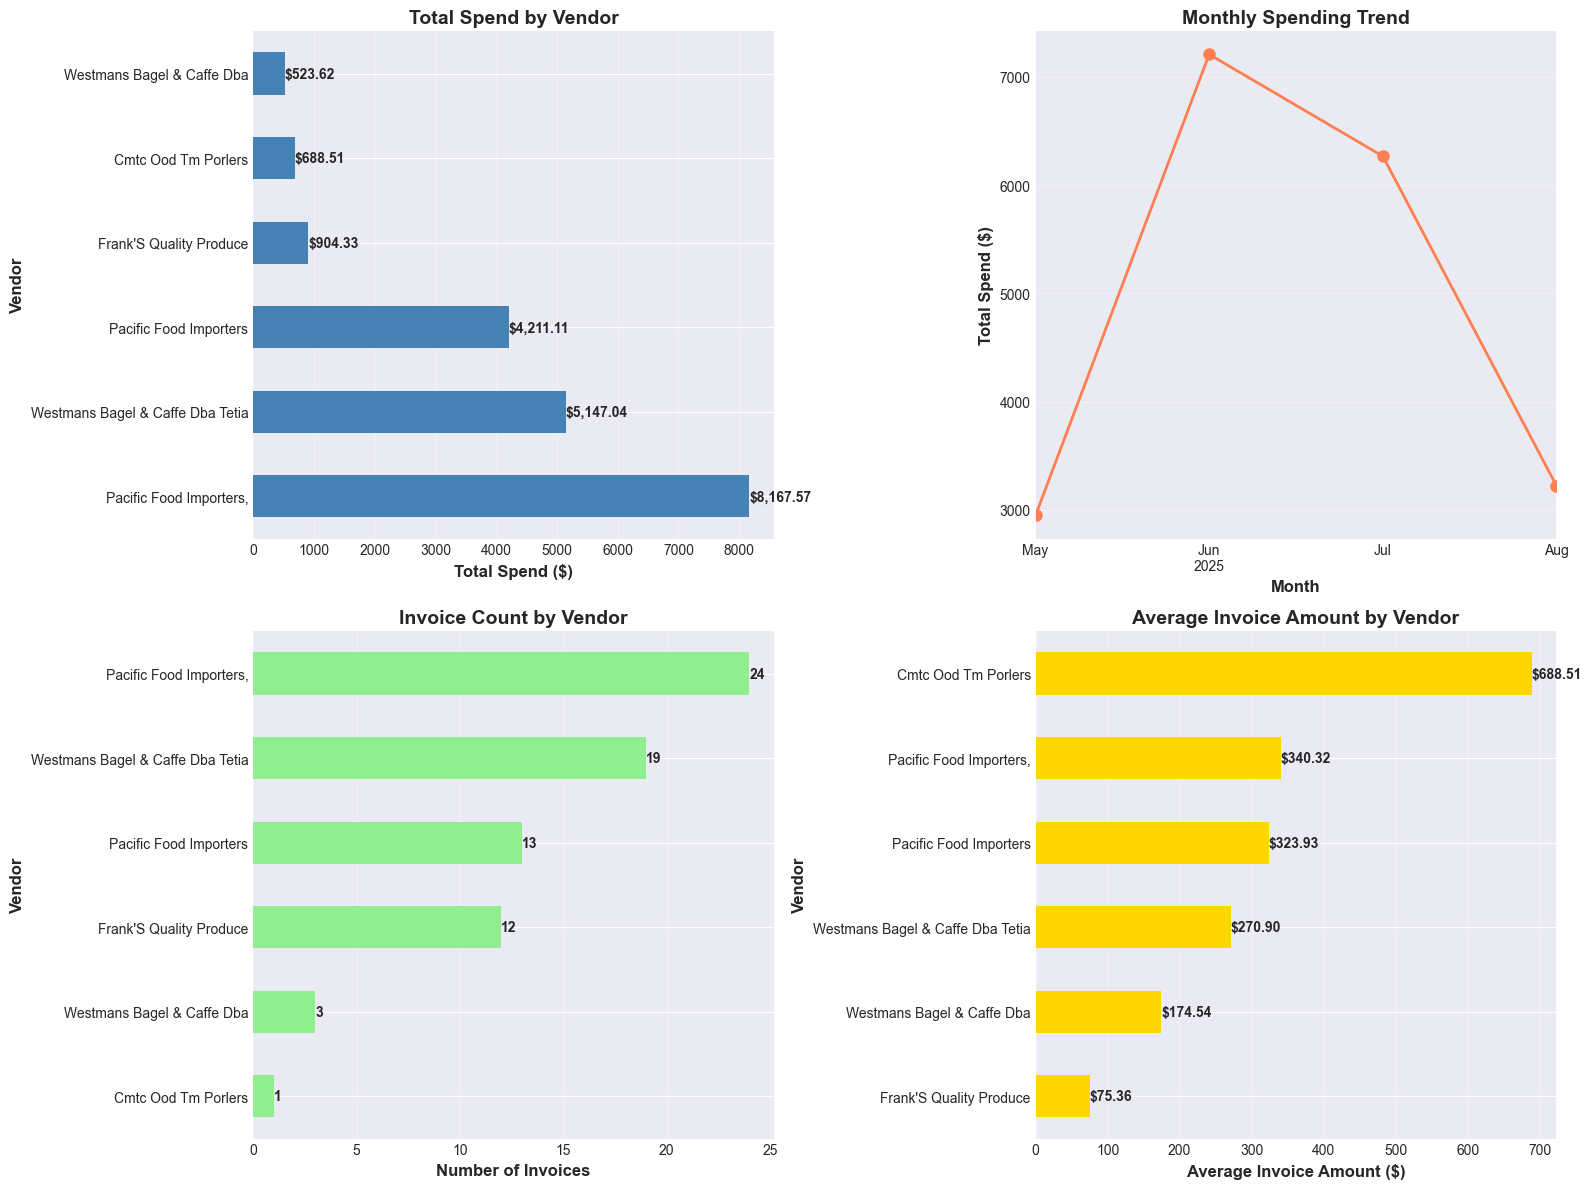

✓ Visualizations created successfully!


In [8]:
# Set up plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

if invoices_df.empty:
    print("⚠ No data available for visualization")
else:
    # 1. Total Spend by Vendor (Bar Chart)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Total Spend by Vendor
    vendor_totals = get_total_spend_by_vendor(invoices_df)
    ax1 = axes[0, 0]
    vendor_totals['total_spend'].plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Total Spend ($)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Vendor', fontsize=12, fontweight='bold')
    ax1.set_title('Total Spend by Vendor', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(vendor_totals['total_spend']):
        ax1.text(v, i, f'${v:,.2f}', va='center', fontweight='bold')
    
    # Chart 2: Monthly Spending Trend
    ax2 = axes[0, 1]
    monthly = get_monthly_spending(invoices_df)
    monthly.index = monthly.index.to_timestamp()
    monthly['total_spend'].plot(kind='line', ax=ax2, marker='o', linewidth=2, markersize=8, color='coral')
    ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Total Spend ($)', fontsize=12, fontweight='bold')
    ax2.set_title('Monthly Spending Trend', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Chart 3: Invoice Count by Vendor
    ax3 = axes[1, 0]
    vendor_counts = invoices_df.groupby('vendor_name')['invoice_number'].count().sort_values(ascending=True)
    vendor_counts.plot(kind='barh', ax=ax3, color='lightgreen')
    ax3.set_xlabel('Number of Invoices', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Vendor', fontsize=12, fontweight='bold')
    ax3.set_title('Invoice Count by Vendor', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    for i, v in enumerate(vendor_counts):
        ax3.text(v, i, str(int(v)), va='center', fontweight='bold')
    
    # Chart 4: Average Invoice Amount by Vendor
    ax4 = axes[1, 1]
    avg_invoice = invoices_df.groupby('vendor_name')['total_amount'].mean().sort_values(ascending=True)
    avg_invoice.plot(kind='barh', ax=ax4, color='gold')
    ax4.set_xlabel('Average Invoice Amount ($)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Vendor', fontsize=12, fontweight='bold')
    ax4.set_title('Average Invoice Amount by Vendor', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(avg_invoice):
        ax4.text(v, i, f'${v:,.2f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations created successfully!")


## 8. Interactive Plotly Dashboard

Create interactive visualizations using Plotly.


In [9]:
if not invoices_df.empty:
    # Create interactive dashboard with Plotly
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Total Spend by Vendor', 'Monthly Spending Trend', 
                       'Invoice Distribution', 'Spending by Extraction Method'),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "pie"}, {"type": "bar"}]]
    )
    
    # 1. Total Spend by Vendor (Bar Chart)
    vendor_totals = get_total_spend_by_vendor(invoices_df)
    fig.add_trace(
        go.Bar(
            x=vendor_totals.index,
            y=vendor_totals['total_spend'],
            name='Total Spend',
            marker_color='steelblue',
            text=[f'${x:,.2f}' for x in vendor_totals['total_spend']],
            textposition='outside'
        ),
        row=1, col=1
    )
    
    # 2. Monthly Spending Trend (Line Chart)
    monthly = get_monthly_spending(invoices_df)
    monthly.index = monthly.index.to_timestamp()
    fig.add_trace(
        go.Scatter(
            x=monthly.index,
            y=monthly['total_spend'],
            mode='lines+markers',
            name='Monthly Spend',
            line=dict(color='coral', width=3),
            marker=dict(size=8)
        ),
        row=1, col=2
    )
    
    # 3. Invoice Distribution by Vendor (Pie Chart)
    vendor_counts = invoices_df.groupby('vendor_name')['invoice_number'].count()
    fig.add_trace(
        go.Pie(
            labels=vendor_counts.index,
            values=vendor_counts.values,
            name="Invoices",
            hole=0.4
        ),
        row=2, col=1
    )
    
    # 4. Spending by Extraction Method (Bar Chart)
    method_totals = invoices_df.groupby('extraction_method')['total_amount'].sum().sort_values(ascending=True)
    fig.add_trace(
        go.Bar(
            x=method_totals.values,
            y=method_totals.index,
            orientation='h',
            name='By Method',
            marker_color='lightgreen',
            text=[f'${x:,.2f}' for x in method_totals.values],
            textposition='outside'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=900,
        title_text="Invoice Analytics Dashboard",
        title_x=0.5,
        showlegend=False,
        font=dict(size=12)
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Vendor", row=1, col=1)
    fig.update_yaxes(title_text="Total Spend ($)", row=1, col=1)
    fig.update_xaxes(title_text="Month", row=1, col=2)
    fig.update_yaxes(title_text="Total Spend ($)", row=1, col=2)
    fig.update_xaxes(title_text="Total Spend ($)", row=2, col=2)
    fig.update_yaxes(title_text="Extraction Method", row=2, col=2)
    
    fig.show()
    
    print("✓ Interactive dashboard created!")
else:
    print("⚠ No data available for interactive dashboard")


✓ Interactive dashboard created!


## 9. Confidence Score Analysis

Analyze confidence scores for extracted invoice fields and extraction methods.


In [ ]:
def analyze_confidence_scores(df: pd.DataFrame):
    """Analyze confidence scores across invoices"""
    if df.empty or 'confidence_score' not in df.columns:
        print("⚠ No confidence score data available")
        return
    
    print("="*80)
    print("📊 CONFIDENCE SCORE ANALYSIS")
    print("="*80)
    
    # Overall statistics
    conf_scores = df['confidence_score']
    print(f"\n Overall Confidence Statistics:")
    print(f"  Mean Confidence:    {conf_scores.mean():.2%}")
    print(f"  Median Confidence:  {conf_scores.median():.2%}")
    print(f"  Min Confidence:     {conf_scores.min():.2%}")
    print(f"  Max Confidence:     {conf_scores.max():.2%}")
    print(f"  Std Deviation:      {conf_scores.std():.2%}")
    
    # Confidence by extraction method
    print(f"\n🔧 Confidence by Extraction Method:")
    method_conf = df.groupby('extraction_method')['confidence_score'].agg(['mean', 'count', 'std']).round(4)
    method_conf.columns = ['Mean Confidence', 'Count', 'Std Dev']
    method_conf['Mean Confidence'] = method_conf['Mean Confidence'].apply(lambda x: f"{x:.2%}")
    display(method_conf)
    
    # Confidence distribution
    print(f"\n Confidence Distribution:")
    bins = [0, 0.5, 0.7, 0.85, 0.95, 1.0]
    labels = ['Low (0-50%)', 'Medium (50-70%)', 'Good (70-85%)', 'High (85-95%)', 'Very High (95-100%)']
    df['confidence_category'] = pd.cut(conf_scores, bins=bins, labels=labels, include_lowest=True)
    conf_dist = df['confidence_category'].value_counts().sort_index()
    for category, count in conf_dist.items():
        pct = (count / len(df)) * 100
        print(f"  {category}: {count} invoices ({pct:.1f}%)")
    
    # Low confidence invoices
    low_conf = df[df['confidence_score'] < 0.7]
    if not low_conf.empty:
        print(f"\n⚠ Low Confidence Invoices (< 70%): {len(low_conf)}")
        print("  These may need manual review:")
        display(low_conf[['invoice_number', 'vendor_name', 'extraction_method', 'confidence_score']].head(10))
    
    print("\n" + "="*80)

# Analyze confidence scores
if not invoices_df.empty and 'confidence_score' in invoices_df.columns:
    analyze_confidence_scores(invoices_df)
else:
    print("⚠ Confidence score data not available in current dataset")


In [ ]:
def calculate_field_level_metrics(database: InvoiceDatabase, ground_truth: Dict[int, Dict] = None):
    """
    Calculate field-level evaluation metrics (Precision, Recall, F1)
    
    Args:
        database: Database instance
        ground_truth: Optional dict mapping invoice_id to ground truth data
                     If None, uses validation status and confidence as proxy
    
    Returns:
        Dictionary with metrics per field
    """
    invoices = database.get_all_invoices()
    
    if not invoices:
        print("⚠ No invoices available for evaluation")
        return None
    
    # Field definitions
    required_fields = ['invoice_number', 'vendor_name', 'date', 'total_amount']
    line_item_fields = ['description', 'quantity', 'unit_price', 'line_total']
    
    metrics = {
        'field_metrics': {},
        'overall_metrics': {},
        'method_metrics': {}
    }
    
    # If ground truth provided, use it; otherwise use validation status
    use_ground_truth = ground_truth is not None
    
    for field in required_fields:
        tp = 0  # True Positives 
        fp = 0  # False Positives
        fn = 0  # False Negatives
        
        for inv in invoices:
            inv_id = inv['id']
            extracted_value = inv.get(field)
            
            if use_ground_truth and inv_id in ground_truth:
                gt_value = ground_truth[inv_id].get(field)
                if extracted_value and gt_value:
                    # Simple string comparison (can be enhanced)
                    if str(extracted_value).strip().lower() == str(gt_value).strip().lower():
                        tp += 1
                    else:
                        fp += 1
                elif extracted_value and not gt_value:
                    fp += 1
                elif not extracted_value and gt_value:
                    fn += 1
            else:
                # Use validation status and confidence as proxy
                if extracted_value and inv.get('validated', False):
                    tp += 1
                elif extracted_value and not inv.get('validated', False):
                    # Check confidence threshold
                    conf = inv.get('confidence_score', 0.0) or 0.0
                    if conf >= 0.7:
                        tp += 1
                    else:
                        fp += 1
                elif not extracted_value:
                    fn += 1
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        metrics['field_metrics'][field] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        }
    
    # Overall metrics (average across fields)
    if metrics['field_metrics']:
        overall_precision = np.mean([m['precision'] for m in metrics['field_metrics'].values()])
        overall_recall = np.mean([m['recall'] for m in metrics['field_metrics'].values()])
        overall_f1 = np.mean([m['f1'] for m in metrics['field_metrics'].values()])
        
        metrics['overall_metrics'] = {
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1
        }
    
    # Metrics by extraction method
    for method in invoices_df['extraction_method'].unique():
        method_invoices = [inv for inv in invoices if inv.get('extraction_method') == method]
        if method_invoices:
            method_tp = sum(1 for inv in method_invoices if inv.get('validated', False))
            method_total = len(method_invoices)
            method_precision = method_tp / method_total if method_total > 0 else 0.0
            
            metrics['method_metrics'][method] = {
                'precision': method_precision,
                'total_invoices': method_total,
                'validated': method_tp
            }
    
    return metrics

def display_evaluation_metrics(metrics: Dict):
    """Display evaluation metrics in a readable format"""
    if not metrics:
        print("⚠ No metrics to display")
        return
    
    print("="*80)
    print("FIELD-LEVEL EXTRACTION METRICS")
    print("="*80)
    
    # Field-level metrics
    if 'field_metrics' in metrics:
        print("\nField-Level Metrics:")
        print("-"*80)
        print(f"{'Field':<20} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'TP':<6} {'FP':<6} {'FN':<6}")
        print("-"*80)
        
        for field, m in metrics['field_metrics'].items():
            print(f"{field:<20} {m['precision']:>10.2%} {m['recall']:>10.2%} {m['f1']:>10.2%} "
                  f"{m['tp']:>5} {m['fp']:>5} {m['fn']:>5}")
    
    # Overall metrics
    if 'overall_metrics' in metrics and metrics['overall_metrics']:
        print("\n" + "-"*80)
        print("📊 Overall Metrics (Average across all fields):")
        om = metrics['overall_metrics']
        print(f"  Precision:  {om['precision']:.2%}")
        print(f"  Recall:     {om['recall']:.2%}")
        print(f"  F1 Score:   {om['f1']:.2%}")
    
    # Method-level metrics
    if 'method_metrics' in metrics:
        print("\n🔧 Metrics by Extraction Method:")
        print("-"*80)
        print(f"{'Method':<20} {'Precision':<12} {'Validated':<12} {'Total':<10}")
        print("-"*80)
        
        for method, m in metrics['method_metrics'].items():
            print(f"{method:<20} {m['precision']:>10.2%} {m['validated']:>11} {m['total_invoices']:>9}")
    
    print("\n" + "="*80)
    print("\nNote: Metrics are calculated using validation status and confidence scores.")
    print("   For more accurate metrics, provide ground truth data.")

# Calculate and display metrics
if not invoices_df.empty:
    print("Calculating field-level evaluation metrics...\n")
    eval_metrics = calculate_field_level_metrics(db)
    if eval_metrics:
        display_evaluation_metrics(eval_metrics)
        
        # Create metrics DataFrame for visualization
        if 'field_metrics' in eval_metrics:
            metrics_df = pd.DataFrame(eval_metrics['field_metrics']).T
            metrics_df = metrics_df[['precision', 'recall', 'f1']]
            print("\n Metrics Summary Table:")
            display(metrics_df)
    else:
        print("⚠ Could not calculate metrics")
else:
    print("⚠ No invoices available for evaluation")


In [ ]:
# Visualize evaluation metrics
if not invoices_df.empty and 'eval_metrics' in locals() and eval_metrics:
    if 'field_metrics' in eval_metrics:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        metrics_df = pd.DataFrame(eval_metrics['field_metrics']).T[['precision', 'recall', 'f1']]
        
        # Chart 1: Precision by Field
        ax1 = axes[0]
        metrics_df['precision'].plot(kind='bar', ax=ax1, color='steelblue')
        ax1.set_ylabel('Precision', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Field', fontsize=12, fontweight='bold')
        ax1.set_title('Precision by Field', fontsize=14, fontweight='bold')
        ax1.set_ylim([0, 1.1])
        ax1.grid(axis='y', alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        for i, v in enumerate(metrics_df['precision']):
            ax1.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
        
        # Chart 2: Recall by Field
        ax2 = axes[1]
        metrics_df['recall'].plot(kind='bar', ax=ax2, color='coral')
        ax2.set_ylabel('Recall', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Field', fontsize=12, fontweight='bold')
        ax2.set_title('Recall by Field', fontsize=14, fontweight='bold')
        ax2.set_ylim([0, 1.1])
        ax2.grid(axis='y', alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        for i, v in enumerate(metrics_df['recall']):
            ax2.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
        
        # Chart 3: F1 Score by Field
        ax3 = axes[2]
        metrics_df['f1'].plot(kind='bar', ax=ax3, color='lightgreen')
        ax3.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Field', fontsize=12, fontweight='bold')
        ax3.set_title('F1 Score by Field', fontsize=14, fontweight='bold')
        ax3.set_ylim([0, 1.1])
        ax3.grid(axis='y', alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        for i, v in enumerate(metrics_df['f1']):
            ax3.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Evaluation metrics visualizations created!")
else:
    print("⚠ Evaluation metrics not available for visualization")


In [ ]:
# Visualize confidence scores
if not invoices_df.empty and 'confidence_score' in invoices_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Confidence distribution histogram
    ax1 = axes[0, 0]
    invoices_df['confidence_score'].hist(bins=20, ax=ax1, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Invoices', fontsize=12, fontweight='bold')
    ax1.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.axvline(invoices_df['confidence_score'].mean(), color='red', linestyle='--', 
                label=f'Mean: {invoices_df["confidence_score"].mean():.2%}')
    ax1.legend()
    
    # Chart 2: Confidence by extraction method (box plot)
    ax2 = axes[0, 1]
    method_order = invoices_df.groupby('extraction_method')['confidence_score'].mean().sort_values(ascending=False).index
    invoices_df.boxplot(column='confidence_score', by='extraction_method', ax=ax2, 
                        vert=True, patch_artist=True)
    ax2.set_xlabel('Extraction Method', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
    ax2.set_title('Confidence by Extraction Method', fontsize=14, fontweight='bold')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Chart 3: Confidence vs Invoice Amount (scatter)
    ax3 = axes[1, 0]
    scatter = ax3.scatter(invoices_df['total_amount'], invoices_df['confidence_score'], 
                          c=invoices_df['confidence_score'], cmap='RdYlGn', 
                          alpha=0.6, s=100, edgecolors='black')
    ax3.set_xlabel('Invoice Amount ($)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
    ax3.set_title('Confidence vs Invoice Amount', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Confidence')
    
    # Chart 4: Average confidence by vendor
    ax4 = axes[1, 1]
    vendor_conf = invoices_df.groupby('vendor_name')['confidence_score'].mean().sort_values(ascending=True)
    vendor_conf.plot(kind='barh', ax=ax4, color='coral')
    ax4.set_xlabel('Average Confidence Score', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Vendor', fontsize=12, fontweight='bold')
    ax4.set_title('Average Confidence by Vendor', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(vendor_conf):
        ax4.text(v, i, f'{v:.2%}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Confidence score visualizations created!")
else:
    print("⚠ Confidence score data not available for visualization")


In [ ]:
if not invoices_df.empty:
    print("="*80)
    print("INVOICE DATA SUMMARY")
    print("="*80)
    
    # Overall statistics
    total_invoices = len(invoices_df)
    total_spend = invoices_df['total_amount'].sum()
    avg_invoice = invoices_df['total_amount'].mean()
    min_invoice = invoices_df['total_amount'].min()
    max_invoice = invoices_df['total_amount'].max()
    
    print(f"\n💰 Financial Summary:")
    print(f"  Total Invoices:     {total_invoices:,}")
    print(f"  Total Spend:        ${total_spend:,.2f}")
    print(f"  Average Invoice:    ${avg_invoice:,.2f}")
    print(f"  Smallest Invoice:   ${min_invoice:,.2f}")
    print(f"  Largest Invoice:    ${max_invoice:,.2f}")
    
    # Vendor statistics
    print(f"\n🏢 Vendor Summary:")
    print(f"  Unique Vendors:     {invoices_df['vendor_name'].nunique()}")
    vendor_totals = get_total_spend_by_vendor(invoices_df)
    for vendor, row in vendor_totals.iterrows():
        print(f"    • {vendor}:")
        print(f"      - Total: ${row['total_spend']:,.2f}")
        print(f"      - Invoices: {int(row['invoice_count'])}")
        print(f"      - Average: ${row['avg_invoice']:,.2f}")
    
    # Date range
    print(f"\n Date Range:")
    print(f"  First Invoice:      {invoices_df['invoice_date'].min().strftime('%Y-%m-%d')}")
    print(f"  Last Invoice:       {invoices_df['invoice_date'].max().strftime('%Y-%m-%d')}")
    print(f"  Span:               {(invoices_df['invoice_date'].max() - invoices_df['invoice_date'].min()).days} days")
    
    # Extraction method statistics
    print(f"\n🔧 Extraction Method Summary:")
    method_stats = invoices_df.groupby('extraction_method').agg({
        'total_amount': ['sum', 'count'],
        'validated': 'sum'
    })
    method_stats.columns = ['Total Spend', 'Count', 'Validated']
    for method, row in method_stats.iterrows():
        print(f"    • {method}:")
        print(f"      - Invoices: {int(row['Count'])}")
        print(f"      - Total: ${row['Total Spend']:,.2f}")
        print(f"      - Validated: {int(row['Validated'])}")
    
    print("\n" + "="*80)
else:
    print("⚠ No invoices available for summary")


📊 INVOICE DATA SUMMARY

💰 Financial Summary:
  Total Invoices:     72
  Total Spend:        $19,642.18
  Average Invoice:    $272.81
  Smallest Invoice:   $-133.42
  Largest Invoice:    $754.89

🏢 Vendor Summary:
  Unique Vendors:     6
    • Pacific Food Importers,:
      - Total: $8,167.57
      - Invoices: 24
      - Average: $340.32
    • Westmans Bagel & Caffe Dba Tetia:
      - Total: $5,147.04
      - Invoices: 19
      - Average: $270.90
    • Pacific Food Importers:
      - Total: $4,211.11
      - Invoices: 13
      - Average: $323.93
    • Frank'S Quality Produce:
      - Total: $904.33
      - Invoices: 12
      - Average: $75.36
    • Cmtc Ood Tm Porlers:
      - Total: $688.51
      - Invoices: 1
      - Average: $688.51
    • Westmans Bagel & Caffe Dba:
      - Total: $523.62
      - Invoices: 3
      - Average: $174.54

📅 Date Range:
  First Invoice:      2025-05-13
  Last Invoice:       2025-08-14
  Span:               93 days

🔧 Extraction Method Summary:
    • claude

## 10. Export Data

Export invoice data to CSV or Excel for further analysis.


In [ ]:
def export_invoices_to_csv(df: pd.DataFrame, filename: str = "invoices_export.csv"):
    """Export invoices to CSV"""
    export_df = df[['invoice_number', 'vendor_name', 'invoice_date', 
                    'total_amount', 'line_items_count', 'extraction_method', 
                    'validated', 'source_file']].copy()
    
    export_df.to_csv(filename, index=False)
    print(f"✓ Exported {len(export_df)} invoices to {filename}")
    return filename

def export_detailed_invoices(database: InvoiceDatabase, filename: str = "invoices_detailed.csv"):
    """Export invoices with line items to CSV"""
    invoices = database.get_all_invoices()
    
    rows = []
    for inv in invoices:
        base_info = {
            'invoice_id': inv['id'],
            'invoice_number': inv['invoice_number'],
            'vendor_name': inv['vendor_name'],
            'invoice_date': inv['invoice_date'],
            'total_amount': float(inv['total_amount']),
            'extraction_method': inv.get('extraction_method', ''),
            'validated': inv.get('validated', False)
        }
        
        line_items = inv.get('line_items', [])
        if line_items:
            for item in line_items:
                row = base_info.copy()
                row['line_item_description'] = item['description']
                row['quantity'] = float(item['quantity'])
                row['unit_price'] = float(item['unit_price'])
                row['line_total'] = float(item['line_total'])
                rows.append(row)
        else:
            rows.append(base_info)
    
    export_df = pd.DataFrame(rows)
    export_df.to_csv(filename, index=False)
    print(f"✓ Exported {len(export_df)} rows (invoices + line items) to {filename}")
    return filename

# Export data
if not invoices_df.empty:
    print("Exporting invoice data...\n")
    
    current_dir = Path.cwd()
    
    csv_file = export_invoices_to_csv(invoices_df, "invoices_summary.csv")
    csv_path = current_dir / csv_file
    
    detailed_file = export_detailed_invoices(db, "invoices_detailed.csv")
    detailed_path = current_dir / detailed_file
    
    print(f"\n{'='*80}")
    print(f"✓ Export complete!")
    print(f"{'='*80}")
    
    if csv_path.exists():
        file_size = csv_path.stat().st_size / 1024  
        print(f"\nFile Info:")
        print(f"  {csv_file}: {file_size:.2f} KB")
    if detailed_path.exists():
        file_size = detailed_path.stat().st_size / 1024  
        print(f"  {detailed_file}: {file_size:.2f} KB")
else:
    print("⚠ No data to export")


📤 Exporting invoice data...

✓ Exported 72 invoices to invoices_summary.csv
✓ Exported 279 rows (invoices + line items) to invoices_detailed.csv

✓ Export complete!
  Summary: invoices_summary.csv
  Detailed: invoices_detailed.csv
